# Learn Pytorch

## 1. Basic models

### Target:  Implement the following using Pytorch
    * Linear regression
    * Multi-layer Perceptron regressor (MLP)
    * RNN/LSTM
    
## Append: Resources
    * https://github.com/vinhkhuc/PyTorch-Mini-Tutorials
    * http://pytorch.org/tutorials/
    * http://pytorch.org/docs/master/
    * Loss functions: http://blog.csdn.net/zhangxb35/article/details/72464152
    * Optimizer: https://ptorch.com/news/54.html

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set_style("ticks")
matplotlib.rcParams['figure.figsize'] = (10.25,7.5)
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}', r'\usepackage{amsfonts}']
matplotlib.rcParams['font.family'] = 'serif'
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm_notebook as tqdm

## Linear Regression

In [3]:
#prepare data
X=np.random.rand(1000,5)
s = np.array([1,2,3,4,5])
err = np.random.rand(1000,1)*0.1
Y = X*s + err

X_train, Y_train = X[0:500,:],Y[0:500,:]
X_test, Y_test = X[500:,:],Y[500:,:]

### scikit-learn linear regression

In [4]:
#sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression(n_jobs=5).fit(X_train, Y_train)
Y_predict = model.predict(X_test)
print "MSE", mean_squared_error(Y_test,Y_predict)

MSE 0.000864241568334


### pytorch linear regression

In [5]:
#pytorch
n_batch, n_dim = 500, X.shape[1]
model = nn.Linear(n_dim,n_dim,bias=False)

X_train_tt, Y_train_tt = Variable(torch.FloatTensor(X_train)), Variable(torch.FloatTensor(Y_train))
loss_fn = nn.MSELoss(size_average=False)

optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.8)

for t in range(5000):
    Y_train_pred = model(X_train_tt)
    loss = loss_fn(Y_train_pred, Y_train_tt)
    
    # compute gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
Y_predict_tt = model(Variable(torch.FloatTensor(X_test))).data.numpy()
print "MSE", mean_squared_error(Y_test,Y_predict_tt)

MSE 0.000926183136769


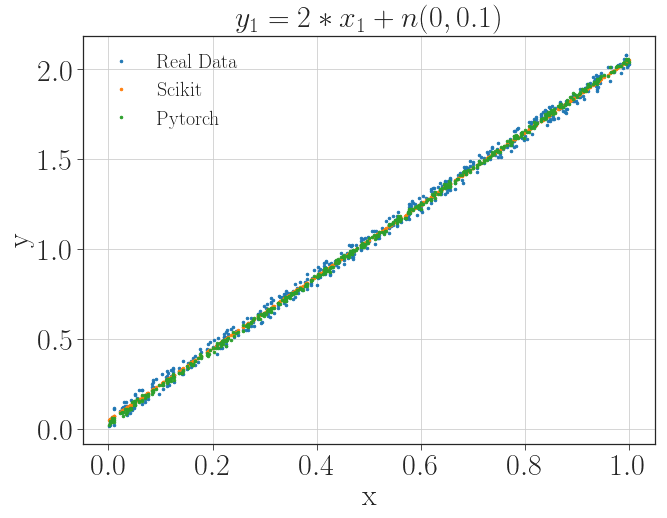

In [17]:
plt.plot(X_test[:,1],Y_test[:,1],'.',markersize=5,label='Real Data')
plt.plot(X_test[:,1],Y_predict[:,1],'.',markersize=5, label='Scikit')
plt.plot(X_test[:,1],Y_predict_tt[:,1],'.',markersize=5, label='Pytorch')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=0)
plt.title(r'$y_1 = 2*x_1 + n(0,0.1)$')

## Multi-layer Perceptron Classifier (MLP)

### Design
    * 3 layers: 5x5x5
    * Activation Function: Relu

2208 items in the time series: 92 days
[  0   0   0 ..., 329   0 236] [ 0.          0.          0.         ...,  2.51851394  0.          2.37474835] [ 0.  0.  0. ...,  3.  0.  3.]


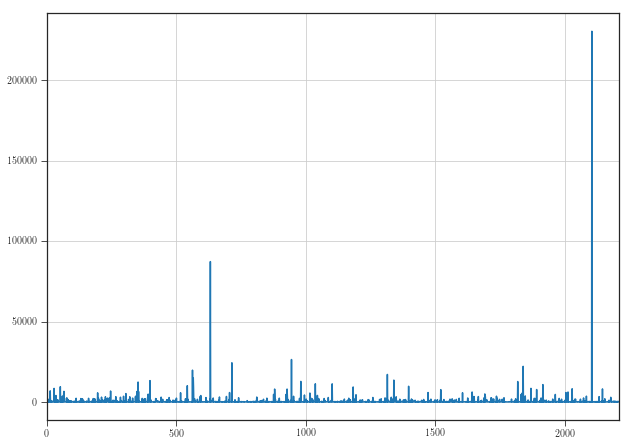

In [5]:
# load data
ts = pd.read_csv('./data/seq.txt',index_col=0,names=['vol'])['vol']
ts.plot(fontsize=10)
print len(ts.values), "items in the time series:", len(ts.values)/24, "days"

vols = ts.values
log10pvols = np.log10(vols+1)
mags = np.ceil(log10pvols)
print vols, log10pvols, mags

In [6]:
from util.markov import timeseries2XY
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

def root_mean_squared_error(*arg):
    return np.sqrt(mean_squared_error(*arg))

## Markov (order=2) predictor

See ('./util/markov.py')

In [8]:
# Markov
import util.markov as markov

order = 2
X,Y = timeseries2XY(mags, order)
X_test, Y_test = X[-24:], Y[-24:]
X_train, Y_train = X[0:-24], Y[0:-24]

print "Y_test", Y_test;

model = markov.MaximumLikelihoodMarkovPredictor(order=order).fit(X_train,Y_train)
Y_predict = model.predict(X_test)
print "Accuracy", accuracy_score(Y_test,Y_predict), "RMSE", root_mean_squared_error(Y_test, Y_predict)
print "Y_predict", Y_predict

Y_test [2.0, 2.0, 2.0, 3.0, 0.0, 2.0, 0.0, 3.0, 0.0, 3.0, 0.0, 2.0, 0.0, 3.0, 0.0, 3.0, 0.0, 3.0, 0.0, 3.0, 0.0, 3.0, 0.0, 3.0]
Accuracy 0.708333333333 RMSE 0.645497224368
Y_predict [ 3.  0.  2.  2.  0.  3.  0.  2.  0.  3.  0.  3.  0.  2.  0.  3.  0.  3.
  0.  3.  0.  3.  0.  3.]


## Scikit MLPClassifier 5X5X5

In [10]:
# Sklearn
from sklearn.neural_network import MLPClassifier, MLPRegressor

X,Y = timeseries2XY(mags, order)
X, Y = np.array(X), np.array(Y).reshape(-1,)
print "X.shape", X.shape, "Y.shape", Y.shape
X_test, Y_test = X[-24:,:], Y[-24:]
X_train, Y_train = X[0:-24,:], Y[0:-24]

model = MLPClassifier(hidden_layer_sizes=(5,5,5),activation='tanh',max_iter=1000)
model = model.fit(X_train,Y_train)
Y_predict =  model.predict(X_test)

print "Accuracy", accuracy_score(Y_test,Y_predict), "RMSE", root_mean_squared_error(Y_test, Y_predict)
print "Y_predict", Y_predict

X.shape (2206, 2) Y.shape (2206,)
Accuracy 0.791666666667 RMSE 0.57735026919
Y_predict [ 3.  0.  2.  2.  0.  3.  0.  3.  0.  3.  0.  3.  0.  3.  0.  3.  0.  3.
  0.  3.  0.  3.  0.  3.]


## Scikit MLPRegressor on Logvalues 5X5X5

In [11]:
# real volume
VX, VY = timeseries2XY(log10pvols, order)
VX, VY = np.array(VX), np.array(VY).reshape(-1,)
VX_train, VX_test = VX[0:-24,:], VX[-24:,:]
VY_train, VY_test = VY[0:-24], VY[-24:]

model = MLPClassifier(hidden_layer_sizes=(5,5,5),activation='relu')
model = model.fit(VX_train,Y_train)
Y_predict =  model.predict(VX_test)

print "Use VX, Y"
print "Accuracy", accuracy_score(Y_test,Y_predict), "RMSE", root_mean_squared_error(Y_test, Y_predict)
print "Y_predict", Y_predict

model = MLPRegressor(hidden_layer_sizes=(5,5,5),activation='tanh',tol=1e-7)
model = model.fit(VX_train, VY_train)
VY_predict = model.predict(VX_test)
print ""
print ""
print "Use VX, VY"

print "VY_predict", VY_predict
Y_predict = np.ceil(VY_predict)
print "Accuracy", accuracy_score(Y_test,Y_predict), "RMSE", root_mean_squared_error(Y_test, Y_predict)

Use VX, Y
Accuracy 0.75 RMSE 0.912870929175
Y_predict [ 3.  0.  0.  0.  0.  3.  0.  3.  0.  3.  0.  3.  0.  3.  0.  3.  0.  3.
  0.  3.  0.  3.  0.  3.]


Use VX, VY
VY_predict [ 2.12738761  0.92741252  1.29473848  1.25497524  0.54536094  2.18078122
  0.82045066  2.08835425  0.5894358   2.12133386  0.3158001   2.18732464
  0.8525374   2.08438716  0.57393767  2.12397197  0.48552213  2.14072826
  0.46325287  2.14552106  0.51046651  2.13566463  0.40431014  2.15974194]
Accuracy 0.375 RMSE 0.790569415042


## Pytorch Classifier

In [ ]:
def build_model_X(n_order, n_classes):
    model = nn.Sequential(
        nn.Linear(n_order, 5, bias=True),
        nn.ReLU(),
        nn.Linear(5,5),
        nn.ReLU(),
        nn.Linear(5,5),
        nn.ReLU(),
        nn.Linear(5,5),
        nn.ReLU(),
        nn.Linear(5, n_classes, bias=True)
    )
    return model

def train(model, loss, optimizer, x_val, y_val):
    x = Variable(x_val, requires_grad=False)
    y = Variable(y_val, requires_grad=False)

    model.train()
    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    output = loss.forward(fx, y)

    # Backward
    output.backward()

    # Update parameters
    optimizer.step()
    return output.data[0] # return loss

def predict(model, x_val):
    x = Variable(x_val, requires_grad=False)
    model.eval()
    output = model.forward(x)
    return output.data.numpy().argmax(axis=1)


X, Y = timeseries2XY(mags, order)
X, Y = np.array(X), np.array(Y)

n_classes = np.unique(Y).size

X, Y = torch.from_numpy(X).float(), torch.from_numpy(Y).long()
print "X.shape", X.shape, "Y.shape", Y.shape, Y.min(), Y.max(), n_classes
X_test, Y_test = X[-24:,:], Y[-24:]
X_train, Y_train = X[0:-24,:], Y[0:-24]

n_examples, n_order =  X.shape
model = build_model_X(n_order, n_classes)

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=0.01,betas=(0.9, 0.99))

batch_size = 48
for i in range(201):
    cost = 0.
    num_batches = n_examples // batch_size
    
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        cost+=train(model, loss, optimizer, X_train[start:end], Y_train[start:end])
            
    Y_predict = predict(model, X_test)
    if i % 50 == 0:
        print("Epoch %d, cost = %f, acc = %f" % (i, cost / num_batches, accuracy_score(Y_test.numpy(),Y_predict)))
        
Y_predict = predict(model, X_test)
Y_test = Y_test.numpy()

print "Accuracy", accuracy_score(Y_test,Y_predict), "RMSE", root_mean_squared_error(Y_test, Y_predict)
print "Y_predict", Y_predict

X.shape torch.Size([2206, 2]) Y.shape torch.Size([2206]) 0 6 7
Epoch 0, cost = 1.595029, acc = 0.750000
Epoch 50, cost = 1.103686, acc = 0.791667
Epoch 100, cost = 1.092139, acc = 0.708333
Epoch 150, cost = 1.090354, acc = 0.708333


## Pytorch Regressor
    * HuberLoss

In [114]:
# PyTorch with customized loss

def build_model_V(n_order):
    return build_model_X(n_order , 1)


def predict_V(model, x_val):
    x = Variable(x_val, requires_grad=False)
    model.eval()
    output = model.forward(x)
    return output.data.numpy()

        
VX, VY = markov.timeseries2XY(np.log10(vols+1), order)
VX, VY = np.array(VX), np.array(VY).reshape(-1,1)
VX, VY = torch.from_numpy(VX).float(), torch.from_numpy(VY).float()

VX_test, VY_test = VX[-24:,:], VY[-24:]
VX_train, VY_train = VX[0:-24,:], VY[0:-24]


n_examples, n_order =  X.shape
model = build_model_V(n_order)

loss = nn.SmoothL1Loss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=1e-2,betas=(0.9, 0.99))

batch_size = 48
for i in range(201):
    cost = 0.
    num_batches = n_examples // batch_size
    
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        cost+=train(model, loss, optimizer, VX_train[start:end], VY_train[start:end])
            
    VY_predict = predict_V(model, VX_test)
    if i % 50 == 0:
        print("Epoch %d, cost = %f, rmse = %f" % (i, cost / num_batches, root_mean_squared_error(VY_test.numpy(),VY_predict)))

print ""
print ""
print "Use VX, VY"
print "VY_predict", VY_predict.reshape(-1)
Y_predict = np.ceil(VY_predict)
print "Accuracy", accuracy_score(Y_test,Y_predict), "RMSE", root_mean_squared_error(Y_test, Y_predict)

Epoch 0, cost = 0.567782, rmse = 1.054055
Epoch 50, cost = 0.562646, rmse = 1.047106
Epoch 100, cost = 0.562540, rmse = 1.047316
Epoch 150, cost = 0.562509, rmse = 1.047155
Epoch 200, cost = 0.562484, rmse = 1.047586


Use VX, VY
VY_predict [ 0.16978988  0.32429567  0.32429567  0.32429567  0.32429567  0.32429567
  0.16978988  0.16978988  0.32429567  0.32429567  0.08087033  0.16978988
  0.32429567  0.32429567  0.32429567  0.32429567  0.32429567  0.32429567
  0.07650459  0.08124566  0.16978988  0.32429567  0.32429567  0.07516974]
Accuracy 0.0 RMSE 1.30703226178


## LSTM 5X5

## Keras

In [143]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,GRU
from keras.layers import LSTM, SimpleRNN
from keras.utils import to_categorical

order = 5
X,Y = timeseries2XY(mags, order)
X, Y, L = np.array(X).reshape(-1,order,1), np.array(Y).reshape(-1,), to_categorical(Y)
print "X.shape", X.shape, "Y.shape", Y.shape, "L.shape", L.shape
X_test, Y_test = X[-24:], Y[-24:]
X_train, Y_train = X[0:-24], Y[0:-24]
L_train, L_test = L[0:-24,:], L[-24:,:]

n_classes = np.unique(Y).size

model = Sequential()
model.add(SimpleRNN(10,input_shape=(order, 1)))
model.add(Dense(n_classes*2, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train,L_train)

L_predict = model.predict(X_test)
Y_predict = L_predict.argmax(axis=1)

print "Accuracy", accuracy_score(Y_test,Y_predict), "RMSE", root_mean_squared_error(Y_test, Y_predict)
print "Y_predict", Y_predict
print "L_predict", L_predict

X.shape (2683, 5, 1) Y.shape (2683,) L.shape (2683, 7)
Epoch 1/10
2659/2659 [==============================] - 1s - loss: 1.3848 - acc: 0.6600     
Epoch 2/10
2659/2659 [==============================] - 0s - loss: 0.8357 - acc: 0.7973     
Epoch 3/10
2659/2659 [==============================] - 0s - loss: 0.8032 - acc: 0.7973     
Epoch 4/10
2659/2659 [==============================] - 0s - loss: 0.7968 - acc: 0.7973     
Epoch 5/10
2659/2659 [==============================] - 0s - loss: 0.7951 - acc: 0.7973     
Epoch 6/10
2659/2659 [==============================] - 0s - loss: 0.7942 - acc: 0.7973     
Epoch 7/10
2659/2659 [==============================] - 0s - loss: 0.7933 - acc: 0.7973     
Epoch 8/10
2659/2659 [==============================] - 0s - loss: 0.7922 - acc: 0.7973     
Epoch 9/10
2659/2659 [==============================] - 0s - loss: 0.7912 - acc: 0.7973     
Epoch 10/10
2659/2659 [==============================] - 0s - loss: 0.7904 - acc: 0.7973     
Accuracy 0.791

## Pytorch Classifier

In [224]:
class LSTMNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LSTMNet, self).__init__()
        hidden_dim = 2*output_dim
        self.hidden_dim = hidden_dim
#         self.lstm = nn.LSTM(input_dim, hidden_dim, 1, batch_first=True)
        self.lstm = nn.GRU(input_dim, hidden_dim, 1, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, output_dim, bias=True)
        self.softmax = nn.Softmax()

    def forward(self, x):
        batch_size = x.size()[0]
        h0 = Variable(torch.zeros([1, batch_size, self.hidden_dim]), requires_grad=False)
        c0 = Variable(torch.zeros([1, batch_size, self.hidden_dim]), requires_grad=False)
#         fx, _ = self.lstm.forward(x, (h0, c0))
        fx, _ = self.lstm.forward(x, (h0))
        y = self.linear1.forward(fx[:,-1,:]) # fx shape is (n_sample, n_t, n_features) so fx[:,-1,:]
        # y is 2d now
        y = self.softmax(y)
#         print y
        return y

    
X, Y = timeseries2XY(mags, order)
X, Y = np.array(X).reshape(-1,order,1), np.array(Y).reshape(-1,)

n_classes = np.unique(Y).size

X, Y = torch.from_numpy(X).float(), torch.from_numpy(Y).long()
print "X.shape", X.shape, "Y.shape", Y.shape, Y.min(), Y.max(), n_classes
X_test, Y_test = X[-24:], Y[-24:]
X_train, Y_train = X[0:-24], Y[0:-24]


n_examples, n_order, _ =  X.shape

model = LSTMNet(1,n_classes)

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

batch_size = int(0.5*n_examples)
for i in range(201):
    cost = 0.
    num_batches = n_examples // batch_size
    
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        cost+=train(model, loss, optimizer, X_train[start:end,:,:], Y_train[start:end])
            
    Y_predict = predict(model, X_test)
    if i % 50 == 0:
        print("Epoch %d, cost = %f, acc = %f" % (i, cost / num_batches, accuracy_score(Y_test.numpy(),Y_predict)))
        
Y_predict = predict(model, X_test)
Y_test = Y_test.numpy()

print "Accuracy", accuracy_score(Y_test,Y_predict), "RMSE", root_mean_squared_error(Y_test, Y_predict)
print "Y_predict", Y_predict

X.shape torch.Size([2682, 6, 1]) Y.shape torch.Size([2682]) 0 6 7
Epoch 0, cost = 1.929229, acc = 0.041667
Epoch 50, cost = 1.402020, acc = 0.791667
Epoch 100, cost = 1.375743, acc = 0.791667
Epoch 150, cost = 1.372383, acc = 0.791667
Epoch 200, cost = 1.371060, acc = 0.791667
Accuracy 0.791666666667 RMSE 1.39940463531
Y_predict [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Pytorch regressor

In [233]:
class LSTMNetV(torch.nn.Module):
    def __init__(self, input_dim):
        super(LSTMNetV, self).__init__()
        hidden_dim = 10
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, 1, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, 5, bias=False)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(5, 1, bias=True)
        
    def forward(self, x):
        batch_size = x.size()[0]
        h0 = Variable(torch.zeros([1, batch_size, self.hidden_dim]), requires_grad=False)
        c0 = Variable(torch.zeros([1, batch_size, self.hidden_dim]), requires_grad=False)
        fx, _ = self.lstm.forward(x, (h0, c0))
        y = self.linear1.forward(fx[:,-1,:]) # fx shape is (n_sample, n_t, n_features) so fx[:,-1,:]
        # y is 2d now
        y = self.linear2(self.relu(y))
        return y



order = 6
VX, VY = timeseries2XY(log10pvols, order)
VX, VY = np.array(VX).reshape(-1,order,1), np.array(VY).reshape(-1,)
VX, VY = torch.from_numpy(VX).float(), torch.from_numpy(VY).float()

VX_test, VY_test = VX[-24:], VY[-24:]
VX_train, VY_train = VX[0:-24], VY[0:-24]


n_examples, n_order, _ =  X.shape
print X.shape

n_features = 1
model = LSTMNetV(n_features)
loss = nn.SmoothL1Loss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.99))

batch_size = 48
for i in tqdm(range(201)):
    cost = 0.
    num_batches = n_examples // batch_size
    
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        cost+=train(model, loss, optimizer, VX_train[start:end], VY_train[start:end])
            
    VY_predict = predict_V(model, VX_test)
    if i % 50 == 0:
        print("Epoch %d, cost = %f, rmse = %f" % (i, cost / num_batches, root_mean_squared_error(VY_test.numpy(),VY_predict)))

VY_predict = predict_V(model,VX_test)
print "Use VX, VY"
print "VY_predict", VY_predict.reshape(-1)
Y_predict = np.ceil(VY_predict).reshape(-1)
print "Accuracy", accuracy_score(Y_test,Y_predict), "RMSE", root_mean_squared_error(Y_test, Y_predict)
print "Y_predict", Y_predict

torch.Size([2682, 6, 1])


A Jupyter Widget

Epoch 0, cost = 0.561210, rmse = 1.039227
Epoch 50, cost = 0.554593, rmse = 1.078191
Epoch 100, cost = 0.552676, rmse = 1.074646
Epoch 150, cost = 0.550764, rmse = 1.075981
Epoch 200, cost = 0.550684, rmse = 1.068827

Use VX, VY
VY_predict [  2.74982095e-01   2.70799249e-01   3.59098077e-01   3.06622505e-01
   4.33725476e-01   5.98865807e-01   1.01531565e-01   3.80863905e-01
   2.61022478e-01   2.12757170e-01   9.26470160e-02  -5.64754009e-04
   3.12596172e-01   3.51333737e-01   3.78630102e-01   5.98865807e-01
   5.98865807e-01   5.98865807e-01   7.23910332e-02   1.37028962e-01
   3.46737772e-01   9.86705422e-02   6.14176393e-02   5.39147854e-03]
Accuracy 0.0416666666667 RMSE 1.29099444874
Y_predict [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -0.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.]
